In [52]:
#keras_timeseries.py
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten    
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.layers.convolutional import Convolution2D
#from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from keras import backend as K

df = pd.read_csv("customers_timeseries_updated.csv")
#df = pd.read_csv("100_timeseries_checking_to_share.csv")
#print (df.columns.values)
#df = df.iloc[:,0:3]
#use column names
df = df[['client_debtor_number','dates','fv_cost']]
#print("new dataset columns ",df.columns.values)
#df.head()
# number of customers
len(df['client_debtor_number'].unique())

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


101

In [2]:
df_1015130 = df[df['client_debtor_number'] == 1015193]
del df_1015130['client_debtor_number']


In [3]:
# try different customers , 1015130-mostly zero with one dip
# 1015193 - more debt after some time,

df_1015130 = df[df['client_debtor_number'] == 1015193]
df_1015130.head()
del df_1015130['client_debtor_number']
# to get client number from list of client numbers use; 
#df[df['client_number'].isin(list_of_values)]\n",
#frequency counts for each customer
# df['client_number'].value_counts()

#df_1015130['client_debtor_number'].value_counts()

In [4]:
#%matplotlib inline
#import seaborn; seaborn.set()
#df_1015130.plot()

print(df_1015130['dates'])
df_1015130.head()

0         10/07/2010
1         11/07/2010
2         12/07/2010
3         13/07/2010
4         14/07/2010
5         15/07/2010
6         16/07/2010
7         17/07/2010
8         18/07/2010
9         19/07/2010
10        26/01/2011
11        27/01/2011
12        28/01/2011
13        29/01/2011
14        30/01/2011
15        31/01/2011
16        01/02/2011
17        02/02/2011
18        03/02/2011
19        04/02/2011
20        14/08/2011
21        15/08/2011
22        16/08/2011
23        17/08/2011
24        18/08/2011
25        19/08/2011
26        20/08/2011
27        21/08/2011
28        22/08/2011
29        23/08/2011
             ...    
307591    14/06/2017
307592    15/06/2017
307593    16/06/2017
307594    17/06/2017
307595    18/06/2017
307596    19/06/2017
307597    20/06/2017
307598    21/06/2017
307599    22/06/2017
307600    23/06/2017
307601    20/12/2017
307602    21/12/2017
307603    22/12/2017
307604    23/12/2017
307605    24/12/2017
307606    25/12/2017
307607    26/

,dates,fv_cost
0,10/07/2010,0.0
1,11/07/2010,0.0
2,12/07/2010,0.0
3,13/07/2010,0.0
4,14/07/2010,0.0


In [19]:

def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])
    
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))

    df.dropna(inplace=True)
    return df


def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

In [20]:
# 3 lags for each data point as input to model
lag =  3

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

#add convolution layer

#Convolution2D (https://keras.io/layers/convolutional/) expects the input to be in the format (samples, rows, cols, channels), 
#which is "channels-last". data is in the format (samples, channels, rows, cols). You should be able to fix
#this using the optional keyword data_format = 'channels_first' when declaring the Convolution2D layer else use
# input_shape=(3,1).
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
#model.add(Flatten()) # as flatten is converting data into 1D but we need 3D for our 3lags data here

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))

# followed by a dense layer with a single output 
model.add(Dense(1))
# we can add dropoutlayer after dense as well again
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [22]:
%%time
i=0

for cust_id, cust_data in df.groupby('client_debtor_number'):
    print ("customer ID",cust_id)
    print ("length", len(cust_data))
    print ("number of iteration",i+1)
    i=i+1
    train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]

    train_x_cust,train_y_cust, scaler = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar = prepare_training_data(test_x['fv_cost'], 3)
    print(train_x_cust.shape)
    print(train_y_cust.shape)
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    
    

customer ID 1015193
length 3478
number of iteration 1
(3189, 1, 3)
(3189,)
Epoch 1/10
 - 18s - loss: 0.0328
Epoch 2/10
 - 18s - loss: 0.0347
Epoch 3/10
 - 18s - loss: 0.0335
Epoch 4/10
 - 18s - loss: 0.0331
Epoch 5/10
 - 18s - loss: 0.0341
Epoch 6/10
 - 18s - loss: 0.0333
Epoch 7/10
 - 19s - loss: 0.0341
Epoch 8/10
 - 18s - loss: 0.0338
Epoch 9/10
 - 18s - loss: 0.0334
Epoch 10/10
 - 17s - loss: 0.0338
Train Score: 0.20 MSE (0.45 RMSE)
Test Score: 0.19 MSE (0.44 RMSE)
unscaled test score 422.496340 MSE
customer ID 1069732
length 3192
number of iteration 2
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0051
Epoch 2/10
 - 16s - loss: 0.0043
Epoch 3/10
 - 17s - loss: 0.0040
Epoch 4/10
 - 17s - loss: 0.0041
Epoch 5/10
 - 16s - loss: 0.0038
Epoch 6/10
 - 16s - loss: 0.0039
Epoch 7/10
 - 16s - loss: 0.0039
Epoch 8/10
 - 16s - loss: 0.0040
Epoch 9/10
 - 17s - loss: 0.0037
Epoch 10/10
 - 17s - loss: 0.0039
Train Score: 0.01 MSE (0.07 RMSE)
Test Score: 0.26 MSE (0.51 RMSE)
unscaled test score

 - 16s - loss: 0.0100
Epoch 2/10
 - 16s - loss: 0.0091
Epoch 3/10
 - 16s - loss: 0.0090
Epoch 4/10
 - 16s - loss: 0.0090
Epoch 5/10
 - 16s - loss: 0.0089
Epoch 6/10
 - 16s - loss: 0.0094
Epoch 7/10
 - 16s - loss: 0.0090
Epoch 8/10
 - 16s - loss: 0.0090
Epoch 9/10
 - 16s - loss: 0.0086
Epoch 10/10
 - 16s - loss: 0.0088
Train Score: 0.08 MSE (0.29 RMSE)
Test Score: 0.36 MSE (0.60 RMSE)
unscaled test score 451.893306 MSE
customer ID 1431777
length 3202
number of iteration 18
(2926, 1, 3)
(2926,)
Epoch 1/10
 - 16s - loss: 0.0242
Epoch 2/10
 - 16s - loss: 0.0224
Epoch 3/10
 - 16s - loss: 0.0221
Epoch 4/10
 - 16s - loss: 0.0223
Epoch 5/10
 - 16s - loss: 0.0228
Epoch 6/10
 - 16s - loss: 0.0224
Epoch 7/10
 - 16s - loss: 0.0225
Epoch 8/10
 - 16s - loss: 0.0224
Epoch 9/10
 - 16s - loss: 0.0221
Epoch 10/10
 - 16s - loss: 0.0226
Train Score: 0.19 MSE (0.44 RMSE)
Test Score: 0.22 MSE (0.47 RMSE)
unscaled test score 150.220378 MSE
customer ID 1434120
length 3198
number of iteration 19
(2922, 1, 3)
(

 - 16s - loss: 0.0031
Epoch 4/10
 - 16s - loss: 0.0033
Epoch 5/10
 - 16s - loss: 0.0031
Epoch 6/10
 - 16s - loss: 0.0031
Epoch 7/10
 - 16s - loss: 0.0032
Epoch 8/10
 - 16s - loss: 0.0030
Epoch 9/10
 - 16s - loss: 0.0030
Epoch 10/10
 - 16s - loss: 0.0030
Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.51 MSE (0.72 RMSE)
unscaled test score -3.267453 MSE
customer ID 1931318
length 3192
number of iteration 34
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0261
Epoch 2/10
 - 16s - loss: 0.0215
Epoch 3/10
 - 16s - loss: 0.0220
Epoch 4/10
 - 16s - loss: 0.0220
Epoch 5/10
 - 16s - loss: 0.0227
Epoch 6/10
 - 16s - loss: 0.0243
Epoch 7/10
 - 16s - loss: 0.0241
Epoch 8/10
 - 16s - loss: 0.0243
Epoch 9/10
 - 16s - loss: 0.0248
Epoch 10/10
 - 16s - loss: 0.0236
Train Score: 0.28 MSE (0.53 RMSE)
Test Score: 0.29 MSE (0.54 RMSE)
unscaled test score 48.630489 MSE
customer ID 1934833
length 3192
number of iteration 35
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0020
Epoch 2/10
 - 16s - loss: 0.

Epoch 4/10
 - 16s - loss: 9.9613e-04
Epoch 5/10
 - 16s - loss: 9.8163e-04
Epoch 6/10
 - 16s - loss: 0.0010
Epoch 7/10
 - 16s - loss: 9.1361e-04
Epoch 8/10
 - 16s - loss: 9.1140e-04
Epoch 9/10
 - 16s - loss: 9.4147e-04
Epoch 10/10
 - 16s - loss: 0.0010
Train Score: 0.05 MSE (0.23 RMSE)
Test Score: 0.11 MSE (0.33 RMSE)
unscaled test score 0.554330 MSE
customer ID 6400280
length 3193
number of iteration 50
(2920, 1, 3)
(2920,)
Epoch 1/10
 - 16s - loss: 0.0157
Epoch 2/10
 - 16s - loss: 0.0138
Epoch 3/10
 - 16s - loss: 0.0139
Epoch 4/10
 - 16s - loss: 0.0142
Epoch 5/10
 - 16s - loss: 0.0140
Epoch 6/10
 - 16s - loss: 0.0139
Epoch 7/10
 - 16s - loss: 0.0140
Epoch 8/10
 - 16s - loss: 0.0139
Epoch 9/10
 - 16s - loss: 0.0144
Epoch 10/10
 - 16s - loss: 0.0139
Train Score: 0.13 MSE (0.36 RMSE)
Test Score: 0.28 MSE (0.53 RMSE)
unscaled test score 221.635792 MSE
customer ID 6524818
length 3192
number of iteration 51
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0064
Epoch 2/10
 - 16s - loss: 0.00

 - 16s - loss: 0.0082
Epoch 6/10
 - 16s - loss: 0.0078
Epoch 7/10
 - 16s - loss: 0.0078
Epoch 8/10
 - 16s - loss: 0.0078
Epoch 9/10
 - 16s - loss: 0.0076
Epoch 10/10
 - 16s - loss: 0.0078
Train Score: 0.10 MSE (0.32 RMSE)
Test Score: 0.28 MSE (0.53 RMSE)
unscaled test score 344.567665 MSE
customer ID 8069905
length 3192
number of iteration 66
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0233
Epoch 2/10
 - 16s - loss: 0.0222
Epoch 3/10
 - 16s - loss: 0.0222
Epoch 4/10
 - 16s - loss: 0.0231
Epoch 5/10
 - 16s - loss: 0.0239
Epoch 6/10
 - 16s - loss: 0.0242
Epoch 7/10
 - 16s - loss: 0.0227
Epoch 8/10
 - 16s - loss: 0.0231
Epoch 9/10
 - 16s - loss: 0.0224
Epoch 10/10
 - 16s - loss: 0.0221
Train Score: 0.21 MSE (0.46 RMSE)
Test Score: 0.12 MSE (0.35 RMSE)
unscaled test score 66.333558 MSE
customer ID 8097194
length 3195
number of iteration 67
(2920, 1, 3)
(2920,)
Epoch 1/10
 - 16s - loss: 0.0077
Epoch 2/10
 - 16s - loss: 0.0066
Epoch 3/10
 - 16s - loss: 0.0064
Epoch 4/10
 - 16s - loss: 0

Epoch 7/10
 - 16s - loss: 0.0082
Epoch 8/10
 - 16s - loss: 0.0085
Epoch 9/10
 - 16s - loss: 0.0080
Epoch 10/10
 - 16s - loss: 0.0080
Train Score: 0.01 MSE (0.09 RMSE)
Test Score: 0.15 MSE (0.39 RMSE)
unscaled test score -15.780056 MSE
customer ID 8459916
length 3738
number of iteration 82
(3440, 1, 3)
(3440,)
Epoch 1/10
 - 19s - loss: 0.0452
Epoch 2/10
 - 18s - loss: 0.0427
Epoch 3/10
 - 18s - loss: 0.0429
Epoch 4/10
 - 18s - loss: 0.0424
Epoch 5/10
 - 18s - loss: 0.0426
Epoch 6/10
 - 18s - loss: 0.0424
Epoch 7/10
 - 18s - loss: 0.0426
Epoch 8/10
 - 19s - loss: 0.0424
Epoch 9/10
 - 18s - loss: 0.0426
Epoch 10/10
 - 18s - loss: 0.0426
Train Score: 0.14 MSE (0.37 RMSE)
Test Score: 0.11 MSE (0.33 RMSE)
unscaled test score 1481.585535 MSE
customer ID 8468052
length 3192
number of iteration 83
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0041
Epoch 2/10
 - 16s - loss: 0.0035
Epoch 3/10
 - 16s - loss: 0.0035
Epoch 4/10
 - 16s - loss: 0.0035
Epoch 5/10
 - 16s - loss: 0.0034
Epoch 6/10
 - 

Epoch 9/10
 - 16s - loss: 0.0071
Epoch 10/10
 - 16s - loss: 0.0070
Train Score: 0.06 MSE (0.25 RMSE)
Test Score: 0.07 MSE (0.26 RMSE)
unscaled test score -105.357017 MSE
customer ID 9977120
length 3192
number of iteration 98
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0350
Epoch 2/10
 - 16s - loss: 0.0349
Epoch 3/10
 - 16s - loss: 0.0342
Epoch 4/10
 - 16s - loss: 0.0339
Epoch 5/10
 - 16s - loss: 0.0327
Epoch 6/10
 - 16s - loss: 0.0338
Epoch 7/10
 - 16s - loss: 0.0333
Epoch 8/10
 - 16s - loss: 0.0334
Epoch 9/10
 - 16s - loss: 0.0327
Epoch 10/10
 - 16s - loss: 0.0317
Train Score: 0.20 MSE (0.45 RMSE)
Test Score: 0.18 MSE (0.42 RMSE)
unscaled test score 4520.119608 MSE
customer ID 9982280
length 3192
number of iteration 99
(2919, 1, 3)
(2919,)
Epoch 1/10
 - 16s - loss: 0.0057
Epoch 2/10
 - 16s - loss: 0.0051
Epoch 3/10
 - 16s - loss: 0.0045
Epoch 4/10
 - 16s - loss: 0.0045
Epoch 5/10
 - 16s - loss: 0.0044
Epoch 6/10
 - 16s - loss: 0.0044
Epoch 7/10
 - 16s - loss: 0.0043
Epoch 8/10
 -

In [53]:
%%time
i=0
train_rmse =[]
test_rmse = []
actual_test_rmse = []
actual_error_scores = list()
for cust_id, cust_data in df.groupby('client_debtor_number'):
#    if i == 10:
#        break
    print ("customer number ",i)
    i=i+1
    train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x_cust,train_y_cust, scaler = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar = prepare_training_data(test_x['fv_cost'], 3)   
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    actual_test_rmse.append(scaler.inverse_transform(testScore))
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    yhat_act = scaler.inverse_transform(testPredict)
    # report performance
    rmse = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act)):], yhat_act))
    print(cust_id," Test RMSE: ",rmse)
    actual_error_scores.append(rmse)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv'] = test_y_cust
    result_prediction['prediction_fv'] = testPredict
    result_prediction.to_csv("predictions/predictions_for_client_"+str(cust_id)+".csv")

customer number  0
1015193  Test RMSE:  315.66768319643796
customer number  1
1069732  Test RMSE:  1.1334282626815835
customer number  2
1080321  Test RMSE:  27.5812998804462
customer number  3
1119250  Test RMSE:  3.985454584936751
customer number  4
1136123  Test RMSE:  334.27664679948947
customer number  5
1139640  Test RMSE:  5.099204608663353
customer number  6
1140689  Test RMSE:  1.8377106985282496
customer number  7
1146580  Test RMSE:  0.39990351890627174
customer number  8
1167669  Test RMSE:  3.4246573362579915
customer number  9
1172447  Test RMSE:  1.3732736346957164
CPU times: user 3min 54s, sys: 1min 21s, total: 5min 16s
Wall time: 2min


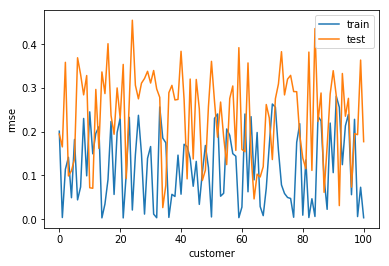

In [50]:
import matplotlib.pyplot as plt
plt.plot(train_rmse,label ="train")
plt.plot(test_rmse,label = "test")
#plt.plot(actual_test_rmse,label = "actual_test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

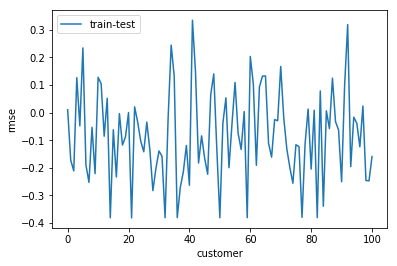

In [41]:
import operator
plt.plot(list(map(operator.sub, train_rmse, test_rmse)),label = "train-test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

Model for each customer series and prediction in the same loop

In [55]:
%%time
i=0
train_rmse =[]
test_rmse = []
actual_train_rmse = []
actual_error_scores_test = list()
for cust_id, cust_data in df.groupby('client_debtor_number'):
    print ("customer number ",i)
    i=i+1
    train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x_cust,train_y_cust, scaler = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar = prepare_training_data(test_x['fv_cost'], 3)  
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    yhat_act_test = scaler.inverse_transform(testPredict)
    # report performance
    rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
    print(cust_id," Test RMSE: ",rmse_test)
    actual_error_scores_test.append(rmse_test)
    yhat_act_train = scaler.inverse_transform(trainScore)
    rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
    actual_train_rmse.append(rmse_train)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv'] = test_y_cust
    result_prediction['prediction_scaled'] = testPredict
    result_prediction['prediction_actual'] = yhat_act_test
    result_prediction.to_csv("predictions_1/predictions_for_client_"+str(cust_id)+".csv")
    model.reset_states()

customer number  0
Epoch 1/10
 - 22s - loss: 0.0290
Epoch 2/10
 - 22s - loss: 0.0283
Epoch 3/10
 - 22s - loss: 0.0280
Epoch 4/10
 - 22s - loss: 0.0281
Epoch 5/10
 - 22s - loss: 0.0281
Epoch 6/10
 - 22s - loss: 0.0282
Epoch 7/10
 - 22s - loss: 0.0279
Epoch 8/10
 - 22s - loss: 0.0282
Epoch 9/10
 - 22s - loss: 0.0282
Epoch 10/10
 - 22s - loss: 0.0282
1015193  Test RMSE:  358.3846779002558
customer number  1
Epoch 1/10
 - 21s - loss: 0.0037
Epoch 2/10
 - 21s - loss: 0.0034
Epoch 3/10
 - 17s - loss: 0.0033
Epoch 4/10
 - 18s - loss: 0.0031
Epoch 5/10
 - 19s - loss: 0.0033
Epoch 6/10
 - 18s - loss: 0.0033
Epoch 7/10
 - 18s - loss: 0.0032
Epoch 8/10
 - 18s - loss: 0.0032
Epoch 9/10
 - 18s - loss: 0.0033
Epoch 10/10
 - 18s - loss: 0.0030
1069732  Test RMSE:  1.173771628390748
customer number  2
Epoch 1/10
 - 18s - loss: 0.0058
Epoch 2/10
 - 19s - loss: 0.0053
Epoch 3/10
 - 21s - loss: 0.0051
Epoch 4/10
 - 21s - loss: 0.0052
Epoch 5/10
 - 20s - loss: 0.0048
Epoch 6/10
 - 20s - loss: 0.0051
Epoch

 - 21s - loss: 0.0759
Epoch 2/10
 - 21s - loss: 0.0043
Epoch 3/10
 - 21s - loss: 0.0029
Epoch 4/10
 - 21s - loss: 0.0031
Epoch 5/10
 - 21s - loss: 0.0028
Epoch 6/10
 - 21s - loss: 0.0026
Epoch 7/10
 - 21s - loss: 0.0029
Epoch 8/10
 - 21s - loss: 0.0029
Epoch 9/10
 - 21s - loss: 0.0025
Epoch 10/10
 - 21s - loss: 0.0023
1555678  Test RMSE:  82.58579922075113
customer number  22
Epoch 1/10
 - 21s - loss: 0.0080
Epoch 2/10
 - 21s - loss: 0.0063
Epoch 3/10
 - 21s - loss: 0.0060
Epoch 4/10
 - 21s - loss: 0.0060
Epoch 5/10
 - 21s - loss: 0.0059
Epoch 6/10
 - 21s - loss: 0.0059
Epoch 7/10
 - 21s - loss: 0.0059
Epoch 8/10
 - 21s - loss: 0.0059
Epoch 9/10
 - 21s - loss: 0.0059
Epoch 10/10
 - 21s - loss: 0.0059
1563037  Test RMSE:  69.9438072244688
customer number  23
Epoch 1/10
 - 21s - loss: 0.0280
Epoch 2/10
 - 21s - loss: 0.0247
Epoch 3/10
 - 23s - loss: 0.0249
Epoch 4/10
 - 22s - loss: 0.0249
Epoch 5/10
 - 22s - loss: 0.0244
Epoch 6/10
 - 21s - loss: 0.0243
Epoch 7/10
 - 21s - loss: 0.0243
E

 - 21s - loss: 0.0011
Epoch 2/10
 - 21s - loss: 0.0012
Epoch 3/10
 - 21s - loss: 0.0012
Epoch 4/10
 - 21s - loss: 0.0011
Epoch 5/10
 - 21s - loss: 0.0011
Epoch 6/10
 - 21s - loss: 0.0012
Epoch 7/10
 - 21s - loss: 0.0012
Epoch 8/10
 - 21s - loss: 0.0012
Epoch 9/10
 - 21s - loss: 0.0012
Epoch 10/10
 - 21s - loss: 0.0013
2267185  Test RMSE:  2.346284479932396
customer number  43
Epoch 1/10
 - 21s - loss: 0.0100
Epoch 2/10
 - 21s - loss: 0.0086
Epoch 3/10
 - 22s - loss: 0.0085
Epoch 4/10
 - 21s - loss: 0.0086
Epoch 5/10
 - 21s - loss: 0.0084
Epoch 6/10
 - 21s - loss: 0.0082
Epoch 7/10
 - 21s - loss: 0.0082
Epoch 8/10
 - 21s - loss: 0.0082
Epoch 9/10
 - 21s - loss: 0.0084
Epoch 10/10
 - 21s - loss: 0.0082
3447510  Test RMSE:  240.0382692185478
customer number  44
Epoch 1/10
 - 21s - loss: 0.0070
Epoch 2/10
 - 21s - loss: 0.0071
Epoch 3/10
 - 21s - loss: 0.0069
Epoch 4/10
 - 21s - loss: 0.0072
Epoch 5/10
 - 21s - loss: 0.0071
Epoch 6/10
 - 21s - loss: 0.0072
Epoch 7/10
 - 21s - loss: 0.0069


 - 22s - loss: 0.0438
Epoch 2/10
 - 22s - loss: 0.0416
Epoch 3/10
 - 22s - loss: 0.0411
Epoch 4/10
 - 22s - loss: 0.0411
Epoch 5/10
 - 23s - loss: 0.0411
Epoch 6/10
 - 22s - loss: 0.0411
Epoch 7/10
 - 22s - loss: 0.0410
Epoch 8/10
 - 23s - loss: 0.0405
Epoch 9/10
 - 22s - loss: 0.0409
Epoch 10/10
 - 23s - loss: 0.0418
8056102  Test RMSE:  201.5367671323846
customer number  64
Epoch 1/10
 - 21s - loss: 0.0075
Epoch 2/10
 - 22s - loss: 0.0078
Epoch 3/10
 - 22s - loss: 0.0076
Epoch 4/10
 - 21s - loss: 0.0077
Epoch 5/10
 - 21s - loss: 0.0075
Epoch 6/10
 - 21s - loss: 0.0077
Epoch 7/10
 - 21s - loss: 0.0076
Epoch 8/10
 - 21s - loss: 0.0077
Epoch 9/10
 - 21s - loss: 0.0075
Epoch 10/10
 - 22s - loss: 0.0075
8056412  Test RMSE:  893.1353659528195
customer number  65
Epoch 1/10
 - 22s - loss: 0.0224
Epoch 2/10
 - 22s - loss: 0.0212
Epoch 3/10
 - 22s - loss: 0.0210
Epoch 4/10
 - 22s - loss: 0.0213
Epoch 5/10
 - 22s - loss: 0.0212
Epoch 6/10
 - 22s - loss: 0.0215
Epoch 7/10
 - 22s - loss: 0.0212


 - 20s - loss: 0.0059
Epoch 2/10
 - 20s - loss: 0.0056
Epoch 3/10
 - 20s - loss: 0.0055
Epoch 4/10
 - 20s - loss: 0.0053
Epoch 5/10
 - 20s - loss: 0.0054
Epoch 6/10
 - 20s - loss: 0.0054
Epoch 7/10
 - 20s - loss: 0.0054
Epoch 8/10
 - 20s - loss: 0.0055
Epoch 9/10
 - 20s - loss: 0.0056
Epoch 10/10
 - 20s - loss: 0.0056
8491232  Test RMSE:  1.7319525480270386
customer number  85
Epoch 1/10
 - 20s - loss: 0.0254
Epoch 2/10
 - 20s - loss: 0.0232
Epoch 3/10
 - 20s - loss: 0.0238
Epoch 4/10
 - 20s - loss: 0.0225
Epoch 5/10
 - 20s - loss: 0.0225
Epoch 6/10
 - 20s - loss: 0.0228
Epoch 7/10
 - 20s - loss: 0.0223
Epoch 8/10
 - 20s - loss: 0.0226
Epoch 9/10
 - 20s - loss: 0.0222
Epoch 10/10
 - 20s - loss: 0.0227
8529930  Test RMSE:  121.41844661476925
customer number  86
Epoch 1/10
 - 20s - loss: 0.0140
Epoch 2/10
 - 20s - loss: 0.0141
Epoch 3/10
 - 20s - loss: 0.0139
Epoch 4/10
 - 20s - loss: 0.0139
Epoch 5/10
 - 20s - loss: 0.0143
Epoch 6/10
 - 20s - loss: 0.0142
Epoch 7/10
 - 20s - loss: 0.013

results

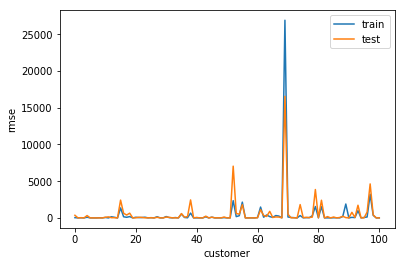

In [56]:
#actual rmse values
import matplotlib.pyplot as plt
plt.plot(actual_train_rmse,label ="train")
plt.plot(actual_error_scores_test,label = "test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

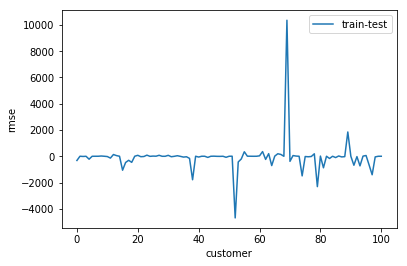

In [57]:
#actual rmse values
import operator
plt.plot(list(map(operator.sub, actual_train_rmse, actual_error_scores_test)),label = "train-test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

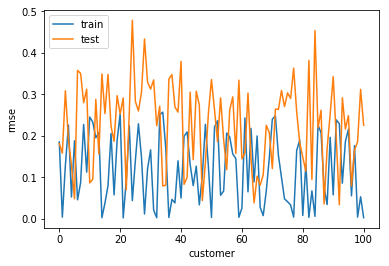

In [58]:
import matplotlib.pyplot as plt
plt.plot(train_rmse,label ="train")
plt.plot(test_rmse,label = "test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

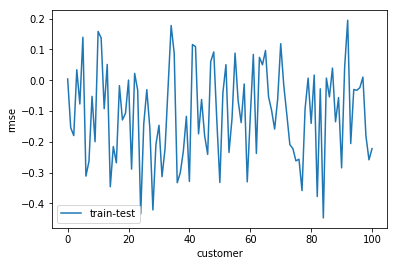

In [59]:
import operator
plt.plot(list(map(operator.sub, train_rmse, test_rmse)),label = "train-test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

Extra code

In [14]:
scaler.inverse_transform(test_y_cust)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.97603556 -0.9636714  -0.95130559 -0.93893812 -0.926569    0.29031932
  0.30811978  0.33047664  0.34872278  0.37122721  0.39373465  0.4162451
  0.27148751  0.29163079  0.31006937 -0.91419823 -0.91419823 -0.92099454
 -0.91649766 -0.90316826 -0.88983707 -0.8765041  -0.86316935 -0.84983281
 -0.8364945   0.33027681  0.35048694  0.37069978  0.39091532  0.41003305
  0.43029187  0.45040125  0.46849455  0.48864712  0.50880238 -0.83230612
 -0.82476944 -0.81169946 -0.79862774 -0.78555427 -0.77431324 -0.76117315
 -0.74803129 -0.73488769 -0.72174232  0.52896034  0.54717047  0.56718363
  0.58719947  0.60721799  0.62723918  0.64726305  0.66728959  0.68731881
  0.70735071 -0.7085952  -0.69544632 -0.68229568 -0.66914328 -0.66025761
 -0.80006778 -0.78735201 -0.77903696 -0.76616627 -0.75329386  0.70735071
  0.68027303  0.65163377  0.67179156  0.69195205  0.71211523  0.72563466
  0.74513523  0.76506493  0.78279628 -0.74041972 -0.72854548 -0.71572565
 -0.70290411 -0.69008085 -0.67725588 -0.6644292  -0.6516008  -0.63950436
 -0.62702743  0.80280707  0.82282053  0.84283667  0.86285549  0.88287698
  0.90290115  0.92292799  0.93954273  0.95969246  0.97984488 -0.61757033
 -0.60457919 -0.59158632 -0.57859171 -0.56559536 -0.57103134 -0.55880759
 -0.54677236 -0.53460875 -0.52244351  1.         -0.86533623 -0.67184821
 -0.85834319 -0.85357313 -0.84348874 -0.90140748 -0.8919321  -0.88245545
 -0.87297753 -0.51027665 -0.49810815 -0.49810815 -0.49489926 -0.49489926
 -0.53045552 -0.51788665 -0.50369568 -0.49488413 -0.48100629 -0.86349835
 -0.8643023  -0.85446661 -0.88832708 -0.87698477 -0.86717734 -0.8558912
 -0.84570406 -0.83437702 -0.82304846 -0.4671266  -0.45324505 -0.45006504
 -0.43799064 -0.42591463 -0.413837   -0.40175775 -0.3896769  -0.37759442
 -0.36551033 -0.81171839 -0.80148732 -0.79048318 -0.78251285 -0.77100867
 -0.75950296 -0.74799571 -0.76498895 -0.75910082 -0.74936347 -0.35342463
 -0.34133731 -0.32924837 -0.31715782 -0.30506565 -0.29297187 -0.2852789
 -0.27321403 -0.26114755 -0.24907945 -0.73962482 -0.72988487 -0.72014361
 -0.71552323 -0.70560308 -0.70008402 -0.69000969 -0.68402206 -0.2417036
 -0.42860998 -0.41686305 -0.41686305 -0.40998507 -0.39810499 -0.38622333
 -0.38622333 -0.45876064 -0.45876064 -0.44641151 -0.43153505 -0.41665661
 -0.41665661 -0.42090721 -0.40536633 -0.38982338 -0.37427835 -0.35873124
 -0.34391572 -0.3283392  -0.3127606  -0.29717992 -0.28159715 -0.26640711
 -0.25083336 -0.28019197 -0.26423943 -0.25843251 -0.24212643 -0.22581818
 -0.20950775 -0.21140346 -0.20063254 -0.1834764  -0.22604758 -0.20900643
 -0.191963   -0.1749173  -0.16227174 -0.20381442 -0.1855679  -0.16731894
 -0.14906754 -0.13081371 -0.13800624 -0.11984827 -0.10168786 -0.08352503
 -0.08352503 -0.08352503 -0.06854807 -0.05283173 -0.03446371 -0.01609324
  0.00227969  0.01845404  0.03617396  0.05465527  0.07313906  0.09162532
  0.11011404  0.12860524  0.14298458  0.16162233  0.17806167  0.19678016
  0.21550115  0.23422464  0.25295063  0.27167913  0.27167913  0.28173922
  0.28173922  0.2879614   0.2637393   0.28472128  0.30570605  0.32669363
  0.34768402  0.36867721  0.33795662  0.35499993  0.37756     0.40012308
  0.40012308  0.41623729  0.43902847  0.43902847  0.43902847  0.45885448
  0.48175391  0.50465641  0.52756197  0.55047059  0.57082118  0.59382407
  0.61683004  0.63561324  0.65783701  0.32191552  0.34810545  0.34810545
  0.37476622  0.27208782  0.28606965  0.25390692  0.27113696  0.29180496
  0.26877825].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# predictions for timesteps ahead
# 7,14 ,21 timesteps ahead
#we need atleast 4 elements to prepare training data
futureElement = testPredict[-4:]

def prepare_training_data_array(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
print(futureElements[0][0][0][:2])

#future_x = np.array(futureElement,futureElements[0][:2])

In [ ]:
cost_lagged

In [ ]:
_7time_ahead,elements = timestep_ahead(7,model,futureElement,x)
print ("scaled prediction value on 7th day ahead ",_7time_ahead)
_14time_ahead,elements  = timestep_ahead(14,model,futureElement,x)
print ("scaled prediction value on 14th day ahead ",_14time_ahead)
_21time_ahead,elements  = timestep_ahead(21,model,futureElement,x)
print ("scaled prediction value on 21st day ahead ",_21time_ahead)

In [ ]:
# 3months ahead predicitons
_91days_ahead,elements = timestep_ahead(91,model,futureElement,x)
print ("scaled prediction value on 91st day ahead ",_91days_ahead)


In [ ]:
daily_pred =[np.array(arr).tolist() for arr in elements]
daily_pred
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
pred_list = flatten(daily_pred)

import csv 
myFile = open('daily_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)

pred_list

In [ ]:
#find every 7th element into a list
week_end_pred = pred_list[0::7]
week_end_pred

In [ ]:
# weekly average for 3 months
weekly_avg_pred = [(sum(pred_list[x:x+7]))/7 for x in range(0, len(pred_list), 7)]
weekly_avg_pred

# find average for every 7 days
import itertools
n=7 #7days
list_week = list(itertools.chain.from_iterable([i]*7 for i in [sum(pred_list[i:i+7])//7 for i in range(0,len(pred_list),7)]))
list_week


#for i in range(7):
futureElement = model.predict(futureElement,batch_size=1)
futureElements.append(futureElement)
futureElement = np.append(futureElement, futureElements[0][0][0][:3])
x=futureElement[:3]
print(x)
print("iteration 0 complete")
#    #return futureElements
print(futureElement)
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 1 complete")
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 2 complete")
print(futureElements)

print(type(futureElements))
print(type(futureElement))

In [ ]:
flat_list = [x for sublist in futureElements for x in sublist]
print(flat_list[0][0][1])

#above function loops in below format
#for sublist in futureElements:
#    for x in sublist:
#        flat_list.append(x)

In [ ]:
#price.resample('1W')  
#aapl.resample('W').mean()
#http://benalexkeen.com/resampling-time-series-data-with-pandas/
#resampling based on days and then slicing every 7th day
#ts.resample('D').interpolate()[::7]

In [ ]:
#df.last('3M') #last 3 months data
# to sort dates column before getting last 3months
#df_sorted = df.sort_values(by="Date",ascending=True) \
#    .set_index("Date")
#    .last("3M")

https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data

https://stats.stackexchange.com/questions/67362/shall-i-use-weekly-or-monthly-data-for-forecast

In [ ]:
#weekly predicitons
#weekly data
week_data = df_1015130.set_index('dates').resample('1W').mean()
#week_data['dates'] = pd.to_datetime(week_data['dates'], errors='coerce')


week_data = week_data.resample('1W')


In [ ]:
#week_data['dates'] = pd.to_datetime(week_data['dates'], unit='D',utc=True)
week_data = df_1015130
##week_data['New']=week_data.dates.map(week_data.set_index('dates').iloc[1:].resample('D').sum().rolling(7,min_periods =1).visit.mean()).shift()
week_data['dates'] = pd.to_datetime(week_data['dates'])


In [ ]:
week_data.set_index('dates',inplace=True)
week_data_resample = week_data.resample('1W').mean()

In [ ]:
week_data_resample.describe()

In [ ]:
#c_index = week_data_resample.index("/2018")
#l2 = l[:c_index]
week_data_resample['dates'] = week_data_resample.index
week_data_resample['dates']=week_data_resample['dates'].astype(str)
week_data_resample = week_data_resample.fillna(0)

In [ ]:
train_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == False]
test_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == True]

train_x_week,train_y_week, scaler = prepare_training_data(train_week['fv_cost'], 3)
test_x_week,test_y_week,scalar = prepare_training_data(test_week['fv_cost'], 3)
print(train_x_week.shape)
print(train_y_week.shape)
print(scaler)

In [ ]:
train_week

In [ ]:
week_data_resample

In [ ]:
lag =  3
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
model.fit(train_x_week, train_y_week, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)

In [ ]:
trainScore = model.evaluate(train_x_week, train_y_week, batch_size=1, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_x_week, test_y_week, batch_size=1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
scaler.inverse_transform(trainScore)


In [ ]:
# generate predictions for training
trainPredict = model.predict(train_x_week,batch_size=1)
testPredict = model.predict(test_x_week,batch_size=1)

In [ ]:
futureElement = testPredict[-4:]

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead_week(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
_12_weeks_ahead,all_pred = timestep_ahead_week(12,model,futureElement,x)
print ("scaled prediction value on 3rd month ahead ",_12_weeks_ahead)
print ("all predicitons ",all_pred)

In [ ]:
# converting list of arrays to lists
#l = [arr.tolist() for arr in l]
#[l.tolist() for l in list1]

#weekly_pred = [arr.tolist() for arr in all_pred] #list object has no attribute tolist
weekly_pred =[np.array(arr).tolist() for arr in all_pred]
weekly_pred

In [ ]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]

In [ ]:
pred_list = flatten(weekly_pred)
pred_list

In [ ]:
csvwriter.writerow(pred_list)

In [ ]:
import csv 
myFile = open('weekly_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)

In [60]:
# Clusters
import zipfile
with zipfile.ZipFile("customer_clusters.zip", 'r') as zip_ref:
    # printing all the contents of the zip file 
    zip_ref.printdir() 
  
    # extracting all the files 
    print('Extracting all the files') 
    zip_ref.extractall() 
    print('Done!') 

File Name                                             Modified             Size
timeseries_eight_clusters.csv                  2019-01-10 11:00:34      7695759
timeseries_features_three_clusters.csv         2019-01-10 10:55:06      7695759
timeseries_features_two_clusters.csv           2019-01-10 10:55:22      7695759
timeseries_fifteen_clusters.csv                2019-01-10 10:56:36      7696246
Extracting all the files
Done!
